# ACSE-7 Inversion & Optimisation - Part B (45 pts) <a class="tocSkip"></a>

This question covers lecture 2-7.

Please read the general instructions in [README.md](./README.md) first!

# Introduction: the Helmholtz equation<a class="tocSkip"/></a>

We consider the following PDE in two dimensions:

$$
  -\frac{\partial^2 u(x,y)}{\partial x^2} - \frac{\partial^2 u(x,y)}{\partial y^2} + c u(x,y) = s(x,y)
$$

which has many applications in e.g. optics, metereology, oceanography. Here $u(x, y)$ is the function we solve for, $s(x,y)$ is a prescribed source term, and $c$ is a scalar coefficient.

We will use the following finite difference discretisation 

$$
\frac{-u_{i-1} + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-u_{i-N_x} + 2u_{i} - u_{i+N_x}}{\Delta y^2} + c u_i = s_i
$$

where we assume a computational grid of $N_y$ rows and $N_x$ columns, giving $n=N_x\cdot N_y$ grid points covering a rectangular domain $L_x \times L_y$.

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import scipy.linalg as sl
import scipy.sparse.linalg as spl
import scipy.linalg as sl
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.optimize as sop
# making slopes
from mpltools import annotation
# Used for some simplistic timing in a few places:
from timeit import default_timer as timer
import pyamg
np.set_printoptions(suppress=True)

The first two terms form the same discretisation of the Laplace operator that we have been using in the lectures: a central finite difference scheme. You can use the following implementation that applies Neumann boundary conditions on all boundaries:

<br>
Note: I've altered this 'laplace_matrix' function, creating and returning the $x$ and $y$ s for each of the grid points ($N_x \times N_y$ )besides Matrix $\underline{\mathbf K}$.

In [2]:
def laplace_matrix(Nx, Ny, Lx=1.0, Ly=1.0):
    """ Form/assemble the discretised Laplace operator assuming all Neumann boundary conditions."""
    dx = Lx/(Nx-1)
    dy = Ly/(Ny-1)
    
    # construct matrix from 5 (off-)diagonals
    n = Nx*Ny
    
    # generate the mesh grid
    X = np.linspace(0, Lx, Nx)
    Y = np.linspace(0, Ly, Ny)
    xi, yi = np.meshgrid(X, Y)
    xi = xi.flatten()
    yi = yi.flatten()


    offsets = [-Nx, -1, 0, 1, Nx]
    diags = []
    # coefficient in front of u_{i-Nx}:
    diags.append(-np.ones(n-Nx)/dy**2)
    # coefficient in front of u_{i-1}:
    diags.append(-np.ones(n-1)/dx**2)
    # main diagonal, will be overwritten later on, but we need some nonzero value for now:
    diags.append(np.ones(n))
    # coefficient in front of u_{i+1}:
    diags.append(diags[1])
    # coefficient in front of u_{i+Nx}:
    diags.append(diags[0])
    K = sp.diags(diags, offsets, format='csr')
    
    # The matrix assembled so far assumed that every grid point has 4 neighbours
    # For the grid points in the top row that miss a neighbour above this is dealt with
    # automatically as the grid number of the neighbour above is outside the range 0<=i<n
    # and the same goes for the bottom row with missing neighbours below.
    # In grid-points i in the left column however, we have connected to grid-points i-1 which are in
    # the right column (and one row above). These entries are unwanted and are removed below.
    
    # loop over left-most column in grid (except first row)
    for i in np.arange(Nx, n, Nx):
        K[i, i-1] = 0.
        K[i-1, i] = 0.
        
    # In the discrete laplace operator with only Neumann boundary conditions
    # the sum over each row should be zero. We can use this property to set the correct
    # values for the main diagonal
        
    K.setdiag(0.)  # reset diagonal
    
    # K.setdiag(-K.sum(axis=1))
    K.setdiag(-np.asarray(K.sum(axis=1)).flatten()) # set to negative of sum over other entries in each row
    
    return K, xi, yi

Additionally you may use the following code to calculate the $x_i$ and $y_i$ coordinates of the grid points on a $N_x\times N_y$ mesh:

In [3]:
Nx = 3
Ny = 3 
n = Nx*Ny
Lx = 1.0
Ly = 1.0
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
X = np.linspace(0, Lx, Nx)
Y = np.linspace(0, Ly, Ny)
xi, yi = np.meshgrid(X, Y)
xi = xi.flatten()
yi = yi.flatten()

# Question B1

Let $\underline{\mathbf K}$ be the matrix returned by this function. You may use the fact that $\underline{\mathbf K}$ is symmetric and positive semi-definite. The linear system of equations associated with the discretisation of the Helmholtz PDE can be written: 

$$
  \left[\underline{\mathbf K} + c \underline{\mathbf I}\right] {\mathbf u} = {\mathbf s}
$$

* For what values of $c$ is the matrix $\underline{\mathbf K} + c \underline{\mathbf I}$ Symmetric Positive Definite? Give a short mathematical proof. You do *not* need to prove that $\mathbf K$ on its own is symmetric and positive semi-definite.

---

## Answer for B1
For any $c$ > 0, $\underline{\mathbf K} + c \underline{\mathbf I}$ is Symmetric Positive Definite.
<br>
<br>
Proof:
<br>
1) $c \underline{\mathbf I}$ is symmetric, and $\underline{\mathbf K}$ is symmetric, thus $\underline{\mathbf K} + c \underline{\mathbf I}$ is symmetric.
<br>
2) we know $\underline{\mathbf K}$ is positive semi-definite, that means for 
$$
\forall  {\bf v}\in{\mathbb{R}}^n,\text{except } \;{\bf v}=0,\;\;
{\bf v}^T \underline{\mathbf K}
{\bf v} \geq 0 \;\;
$$

if we choose $\forall \, c$ > 0, we have:
$$
\begin{aligned}
\forall  {\bf v}\in{\mathbb{R}}^n,\text{except } \;{\bf v}=0,\;{\bf v}^T \left(\underline{\mathbf K} + c \underline{\mathbf I}\right) {\bf v}&= {\bf v}^T \underline{\mathbf K}
{\bf v} + c \;{\bf v}^T \underline{\mathbf I} {\bf v}\\
&={\bf v}^T \underline{\mathbf K}
{\bf v} + c \;{\bf v}^T {\bf v}\\
&> 0 \; (\text{because the first term is non-zero and the second term is strictly positive})
\end{aligned}
$$
then $\underline{\mathbf K} + c \underline{\mathbf I}$ is Positive Definite.
<br>
<br>
<br>
In conclusion, if $c$ is a positive number, then $\underline{\mathbf K} + c \underline{\mathbf I}$ is Symmetric Positive Definite (SPD).

# Question B2

On a unit square ($L_x=L_y=1$) with a source term

$$
  s(x, y) = \left(8\pi^2+c\right) \cos(2\pi x)\cos(2\pi y)
$$

the analytical solution is given by

$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$

* Solve the discretised equation with the given source term for a series of increasing grid resolution using the (unpreconditioned) Conjugate Gradient method using a relative tolerance of $\varepsilon_{\text rel}=10^{-5}$. Use a value of $c=1$. Plot the number of required iterations versus the number of grid points $n$ and analyse its asymptotic behaviour. Discuss how this behaviour could be improved. For the Conjugate Gradient method you may use the implementation from the lecture notes, or use [`scipy.sparse.linalg.cg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) (but see lecture 5 how you can use `SimpleCounter` to obtain iteration counts).

---

## Answer for B2

First, we will define the analytical solution 
$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$

as well as the source term

$$
  s(x, y) = \left(8\pi^2+c\right) \cos(2\pi x)\cos(2\pi y)
$$

given an $N_x\times N_y$ mesh, and store the values in 1-D arrays with $N_x\times N_y$ elements.

In [4]:
def u_exact(xi, yi):
    return np.cos(2 * np.pi * xi) * np.cos(2 * np.pi * yi)

In [5]:
def s_function(xi, yi):
    return (8 * np.pi **2 + 1) * np.cos(2 * np.pi * xi) * np.cos(2 * np.pi * yi)

We borrow the `SimpleCounter` function in lecture 5, to obtain iteration counts in Conjugate Gradient:

In [6]:
# borrow from lecture-5
class SimpleCounter:
    """Simple counter object that records how many times it has been called"""
    def __init__(self):
        self.count = 0
    
    def __call__(self, *args):
        """Counts each call, ignore any arguments"""
        self.count += 1

Then we'll solve the discretised equation with the given source term using the (unpreconditioned) Conjugate Gradient method with a relative tolerance of $\epsilon_{rel} = 10^{−5}$
and $c=1$, for a series of different grid sizes : $10 \times 10, \, 20 \times 20, \, 40 \times 40, \, 80 \times 80, \,\text{and} \, 160 \times 160 $, 
then we will have the size of the discretised matrix being $100 \times 100, \, 400 \times 400, \, 1600 \times 1600, \, 6400 \times 6400, \,\text{and} \, 25600 \times 25600 $, we call this size as Degrees of Freedom $n$.

In [7]:
# gettingideas from lecture-5
# setting two arrays to store RMS errors and iteration numbers of CG for different mesh sizes.
RMS_error_cg = []
its_cg = []
# a series of grid sizes
nxs = [10, 20, 40, 80, 160]
ns = []
# a unit square
Lx = 1
Ly = 1

# solve for each size
for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    n = nx**2
    # note here c = 1
    K = K + sp.eye(n)
    s = s_function(xi, yi)
    counter = SimpleCounter()
    x, info_cg = spl.cg(K,s, tol=1e-5, callback=counter)
    its_cg.append(counter.count)
    RMS_error_cg.append(la.norm(x - u_exact(xi, yi)) / n )
    ns.append(n)

print("Degrees Of Freedom:", ns)
print("RMS error (to the exact solution) for Conjugate Gradient:", RMS_error_cg)
print("Iterations Conjugate Gradient:", its_cg)

Degrees Of Freedom: [100, 400, 1600, 6400, 25600]
RMS error (to the exact solution) for Conjugate Gradient: [0.08184085504477343, 0.010800265412827217, 0.0015815825052557853, 0.0002810651449575996, 6.040377223886138e-05]
Iterations Conjugate Gradient: [14, 33, 65, 123, 232]


We could see from the result that finer resolution gives a better approximation to the exact solution (decrease in RMS error). However, the Iterations used are increasing as the mesh size increasing.<br>
Let's make a log-log plot to better observe this:

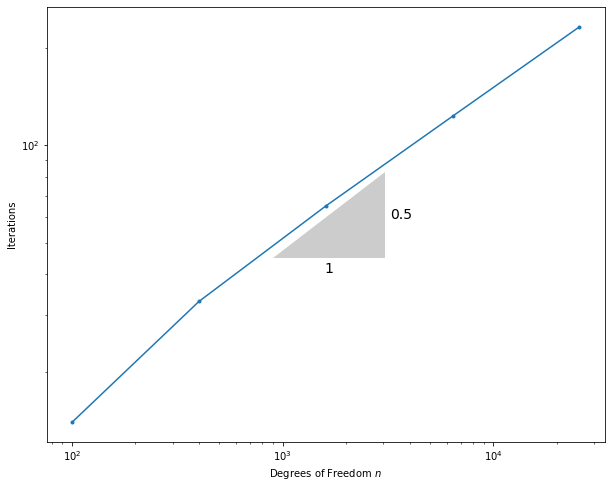

In [8]:
# getting ideas from lecture-5
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.loglog(ns, its_cg, '.-', label='Conjugate Gradient')
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Iterations')
annotation.slope_marker((900, 45), (0.5, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))


From the log-log plot, we could see that the required number of iterations is roughly proportional to $\sqrt{n}$. The reason for that is the condition number 
$$
  \kappa(\underline{\mathbf K} + c \underline{\mathbf I}) = \frac{\mu_{\text max}}{\mu_{\text min}} \propto \frac 1{\Delta x^2}= N_x^2=n \;\left(\text{$\mu$ s are eigenvalues for the matrix}\right)
$$
of the matrix increases linearly with increasing $n$.<br>
We could observe this using the following code:

In [9]:
# getting idea from lecture 5
kappa = []
for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    K = K + sp.eye(nx ** 2)
    w1, v1 = spl.eigsh(K, k=1, tol=0.1) # ask for largest eigenvalue only
    w2, v2 = spl.eigsh(K, k=1, tol=0.1, which='SA')  # ask for smallest eigenvalue only
    kappa.append(w1[0]/w2[0])
    
print("Degrees of freedom: ", ns)
print("kappa =", kappa)

Degrees of freedom:  [100, 400, 1600, 6400, 25600]
kappa = [633.11821826626, 2866.667595243016, 12098.307482844748, 49690.66214262331, 201449.118240082]


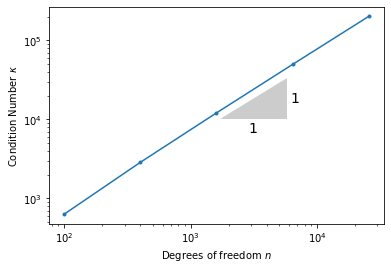

In [10]:
plt.loglog(ns, kappa, '.-')
plt.xlabel('Degrees of freedom $n$')
plt.ylabel('Condition Number $\kappa$')
annotation.slope_marker((1.7e3, 1e4), (1, 1),
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

As the performance of the Conjugate Gradient seem strongly dependent on the condition number which increases with problem size, we could combine stationary methods as Preconditioner for CG. <br>
Consider an iteration of the form:

\begin{align*}
{\bf x}^{(k+1)} &= {\bf x}^{(k)} + \alpha_k\underline{\mathbf P}{\bf r}^{(k)} \\
    &= {\bf x}^{(k)} + \alpha_k\left(\underline{\mathbf P}{\bf b} - \underline{\mathbf P}~\underline{\mathbf A}{\bf x}^{(k)}\right)
\end{align*}

It is equivalent to applying the Conjugate Gradient method to the following modified linear system:

$$
  \underline{\mathbf P}~\underline{\mathbf A} {\bf x} = \underline{\mathbf P}{\bf b}
$$

If we assume $\underline{\mathbf P}$ is invertible, this is equivalent to the linear system $\underline{\mathbf A}{\bf x}={\bf b}$.

Also, we will normally require $\underline{\mathbf P}$ to be SPD, then $\underline{\mathbf P}~\underline{\mathbf A}$ would also be SPD to ensure CG will work.

If $\underline{\mathbf P}=\underline{\mathbf M}^{-1}$ is a good approximation of the inverse of $\underline{\mathbf A}$ then the CG will converge considerably faster because the condition number of the modified system, almost does not increase with size.

In the following we will introduce the SSOR Preconditioner, as well as the Algebraic Multigrid Preconditioner.<br>
<br>
First, we take the `Preconditioner` class from lecture-5:

In [11]:
# taking from lecture-5
class Preconditioner(spl.LinearOperator):
    def __init__(self, A):
        super().__init__(dtype=None, shape=A.shape)
    
    def __call__(self, r):
        raise NotImplemented("The call method should be overloaded")
        
    def _matvec(self, r):
        return self(r)

### The SSOR Preconditioner (borrowed from lecture-5)
For our matrix $\underline{\mathbf A}$, if we decompose it by the addition of an upper-triangle $\underline{\mathbf U}$, a lower-triangle $\underline{\mathbf L}$ and a diagonal Matrix $\underline{\mathbf D}$, that is
<br>
<br>
$$
\underline{\mathbf A} = \underline{\mathbf L} + \underline{\mathbf D} + \underline{\mathbf U}
$$

<br>
We define Symmetric Successive Over-Relaxation (SSOR) Preconditioner $\underline{\mathbf P} = \underline{\mathbf M}^{-1}$, where 

$$
  \underline{\mathbf M} = \frac 1{\omega(2-\omega)} \left[\underline{\mathbf D} + \omega\underline{\mathbf L}\right]\underline{\mathbf D}^{-1}\left[\underline{\mathbf D} + \omega\underline{\mathbf U}\right]
$$
for some $0 \lt \omega \lt 2$. <br>
This method preserves the symmetric property, because if A is SPD,

$$
  \underline{\mathbf A}=\underline{\mathbf A}^T \implies \underline{\mathbf U} = \underline{\mathbf L}^T \implies \underline{\mathbf M}=\underline{\mathbf M}^T
$$

In [12]:
# taking from lecture-5
class SSORPreconditioner(Preconditioner):
    """SSOR method"""
    def __init__(self, A, omega=1.0):
        super().__init__(A)
        self.DOL = sp.tril(A)  # DOL = D + L
        self.DOU = sp.triu(A)  # DOU = D + U
        if not omega==1.0:
            # add (omega-1)*L and (omega-1)*U resp.
            # see comments in GaussSeidelPreconditioner
            self.DOL += (omega-1.0)*sp.tril(A, -1)
            self.DOU += (omega-1.0)*sp.triu(A, 1)
            
        # every iteration we need to compute M^-1 r
        # from the definition of M above we get
        #   M^-1 = omega*(2-omega) * DOU^-1 * D * DOL^-1
        # (note the order is swapped)
        
        # we combine the steps of multiplying with the diagonal matrix M
        # and multiplying with the scalar omega*(2-omega) by scaling the diagonal:
        self.diag = A.diagonal()*(omega*(2-omega))    
        
    def __call__(self, r):
        # 1) do a lower triangular solve with DOL
        # 2) multiply with self.diag = diagonal(A)*omega*(2-omega)
        # 3) do a upper triangulaer solve with DOU using spsolve_triangular(..., lower=False)
        return spl.spsolve_triangular(self.DOU, self.diag * spl.spsolve_triangular(self.DOL, r), lower=False)

Let's observe how the choice of $\omega$ influence the convergence of CG.

In [13]:
# set up a mesh of DOF 40 * 40
nx = 40
K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
n = nx**2
K = K + sp.eye(n)
s = s_function(xi, yi)

For omegas: [0.5        0.57777778 0.65555556 0.73333333 0.81111111 0.88888889
 0.96666667 1.04444444 1.12222222 1.2        1.27777778 1.35555556
 1.43333333 1.51111111 1.58888889 1.66666667 1.74444444 1.82222222
 1.9       ]
Required SSOR iterations: [70, 65, 60, 55, 52, 55, 52, 48, 44, 41, 39, 37, 36, 35, 34, 33, 34, 35, 39]


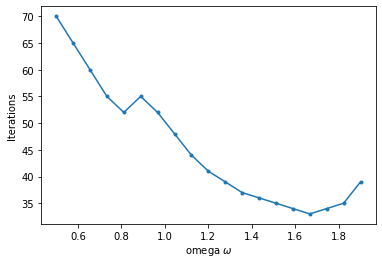

In [14]:
# finding the optimal omega for this mesh size, borrow from lecture-5
omegas = np.linspace(0.5,1.9,19)
its_ssor = []
for omega in omegas:
    counter = SimpleCounter()
    x, info_cg = spl.cg(K,s, tol=1e-5, callback=counter, M=SSORPreconditioner(K, omega=omega))
    its_ssor.append(counter.count)
    
print("For omegas:", omegas)
print("Required SSOR iterations:", its_ssor)
plt.plot(omegas, its_ssor, '.-')
plt.xlabel('omega $\omega$')
plt.ylabel('Iterations');

From the result, we can see an $\omega$ value between $[1,4, 1.8]$ may perform better than others. 

### Algebraic Multigrid Preconditioner (borrowed from lecture-5)

(Paraphrasing from lecture-5)
Multigrid methods are designed to also effectively handle the large scale component of the residual. We apply a smoother to our approximate solution, which means projecting it into a coarser grid, and also a residual on that coarser grid is computed. And then we apply a smoother but now on the coarse-grid residual, it will now also filter out some larger scale components of the residual. If we repeat this process, we could arrive at a grid that is so coarse with is not much difference anymore between the large scale and the grid scale.

The Algebraic Multigrid (AMG) Preconditioner only takes the (Algebraic Properties of) discretised Matrix as input, without accessing the discretisation method used to assemble the original system.

To implement the Algebraic Multigrid (AMG) Preconditioner, we need the `pyamg` package.

In [15]:
# borrow from lecture-5
class AMGPreconditioner(Preconditioner):
    """AMG preconditioner - wraps around pyamg's ruge_stuben_solver"""
    def __init__(self, A):
        super().__init__(A)
        ml = pyamg.ruge_stuben_solver(A.tocsr(), strength=('classical'))
        self.gamg = ml.aspreconditioner()
        
    def __call__(self, r):
        return self.gamg(r)

Let's compare the iterations needed with those two Preconditioners, on same grid sizes as before : $10 \times 10, \, 20 \times 20, \, 40 \times 40, \, 80 \times 80, \,\text{and} \, 160 \times 160 $. (for SSOR, we just taking $\omega = 1.7$)

In [17]:
# define two array to store iteration numbers for two preconditioners
its_cg_SSOR =[]
its_cg_AMG =[]
for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    n = nx**2
    # note here c = 1
    K = K + sp.eye(n)
    s = s_function(xi, yi)
    counter = SimpleCounter()
    x, info_cg = spl.cg(K,s, tol=1e-5, callback=counter, M=SSORPreconditioner(K, omega=1.7))
    its_cg_SSOR.append(counter.count)
    counter = SimpleCounter()
    x, info_cg = spl.cg(K,s, tol=1e-5, callback=counter, M=AMGPreconditioner(K))
    its_cg_AMG.append(counter.count)
    
    

print("Iterations with unpreconditioned Conjugate Gradient:", its_cg)
print("Iterations with SSOR-preconditioned Conjugate Gradient (omega = 1.7):", its_cg_SSOR)
print("Iterations with AMG-preconditioned Conjugate Gradient:", its_cg_AMG )

Iterations with unpreconditioned Conjugate Gradient: [14, 33, 65, 123, 232]
Iterations with SSOR-preconditioned Conjugate Gradient (omega = 1.7): [15, 23, 33, 53, 87]
Iterations with AMG-preconditioned Conjugate Gradient: [4, 4, 5, 7, 8]


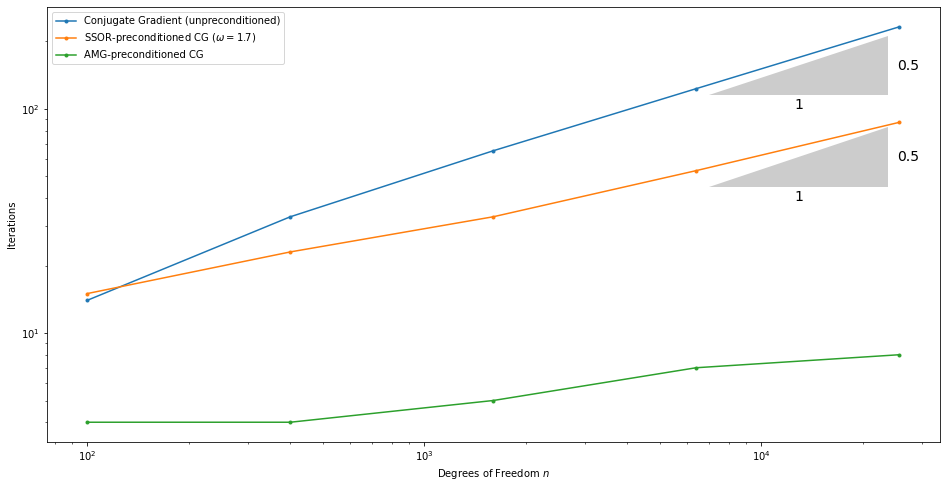

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.loglog(ns, its_cg, '.-', label='Conjugate Gradient (unpreconditioned)')
ax.loglog(ns, its_cg_SSOR, '.-', label=r'SSOR-preconditioned CG ($\omega = 1.7$)')
ax.loglog(ns, its_cg_AMG, '.-', label='AMG-preconditioned CG')
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Iterations')
annotation.slope_marker((7e3, 45), (0.5, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((7e3, 115), (0.5, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.legend()

From the plot we could observe that adding Preconditioners could reduce the number of iterations used for Conjugate Gradient. But more specifically, the iterations for SSOR-Preconditioner still has the same increasing rate as the unpreconditioned one. The AMG-Preconditioner use far more fewer iterations than those two, and also it is quite stable, not showing a significant increasing rate with the Degrees of Freedom $n$.

# Question B3

We now modify the PDE through the addition of a nonlinear term:
    
$$
  -\alpha\frac{\partial^2 u(x,y)}{\partial x^2} - \alpha\frac{\partial^2 u(x,y)}{\partial y^2} + u + \arctan(u) = s(x,y)
$$

where we have also introduced a new scalar coefficient $\alpha$ to scale the Laplacian term. In this, and all of the following questions use $\alpha=10^{-1}$.

A discrete solution can be obtained by solving the nonlinear system of equations

$$
  {\mathbf F}({\mathbf u}) = \alpha\underline{\mathbf K} {\mathbf u}
  + {\mathbf u}
  +  \arctan(\mathbf{u})
  - {\mathbf s} = {\mathbf 0}
$$

where $\underline{\mathbf K}$ is the same discrete Laplace matrix as before, $\mathbf u$ and $\mathbf s$ are vectors that contain the numerical solution, and the source term at the grid points. $\arctan(\mathbf{u})$ is the vector calculated as the $\arctan$ function applied to every component of $\mathbf u$ (use [`numpy.arctan`](https://numpy.org/doc/stable/reference/generated/numpy.arctan.html) in your implementation).

We use a source term of the form

$$
  s(x, y) = \left(\alpha 8\pi^2 + 1\right) \cos(2\pi x)\cos(2\pi y) + \arctan(\cos(2\pi x) \cos(2\pi y))
$$

so that the (continuous) nonlinear PDE has the same analytical solution as previously:

$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$

* Implement the nonlinear, discretised PDE model, by solving the root-finding problem ${\mathbf F}({\mathbf u})={\mathbf 0}$ using Broyden's method. To do this, implement a python function `F(u)` that takes in a numpy array representing the numerical solution ${\mathbf u}$, and returns a numpy array with the values of ${\mathbf F}({\mathbf u})$. Then solve the non linear system of equations using
```python
    result = scipy.optimize.root(F, u0, method='broyden1', options={'disp': True, 'ftol': 1e-5, 'maxiter': 2000})
```
where `u0` is a reasonable initial guess (you could use ${\mathbf u_0}={\mathbf 0}$). Use either Broyden's good (`method=broyden1`) or Broyden's bad method (`method='broyden2'`). Carefully inspect the returned `result` dictionary as the method will not always be succesful! See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html and https://docs.scipy.org/doc/scipy/reference/optimize.root-broyden1.html for more documentation, but the options indicated above should suffice.<br>
Test the solver on a number of small meshes, e.g. $n=5 \times 5, n=10\times 10, n=20\times 20, \dots$ that can be run in a reasonable amount of time. You do not need to time your solves, but each solve should take no longer than a few minutes. Show that you have checked you obtain an accurate solution. What do you observe as the grid resolution increases? (include number of iterations in your observation).

---

## Answer for B3

First, we define $\alpha$ value as well as the source term for this question

$$
  s(x, y) = \left(\alpha 8\pi^2 + 1\right) \cos(2\pi x)\cos(2\pi y) + \arctan(\cos(2\pi x) \cos(2\pi y))
$$

In [19]:
alpha = 1e-1
coeff = alpha * 8 * np.pi **2 + 1

In [20]:
def s_function(xi, yi):
    mult = np.cos(2 * np.pi * xi) * np.cos(2 * np.pi * yi)
    return coeff * mult + np.arctan(mult) 

Then we should define ${\mathbf F}$, which takes $\underline{\mathbf K}, \mathbf u, \mathbf s $ as argument:
$$
  {\mathbf F}({\mathbf u}) = \alpha\underline{\mathbf K} {\mathbf u}
  + {\mathbf u}
  +  \arctan(\mathbf{u})
  - {\mathbf s}
$$

In [21]:
def F(u):
    return alpha * K @ u + u + np.arctan(u) - s

Next, we would like to implement Broyden's good method and Broyden's bad method to solve $$
  {\mathbf F}({\mathbf u}) = 0
$$

We solve this problem for a series of some small grid sizes : $5 \times 5, 10 \times 10, \, 15 \times 15, \, 20 \times 20, \, 25 \times 25, \, 30 \times 30 \, \text{and} \, 35 \times 35$, with the corresponding Degrees of Freedom $n$ is $25, 100, 225, 400, 625, 900 \,\text{and}\, 1225$.  <br>
Also, we will compute the RMS error of our solution with the exact solution 
$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$

***Note: this cell takes a few minutes to run!***

In [22]:
# the array of mesh sizes we use
nxs = [5, 10, 15, 20, 25, 30, 35]
ns =[]

# create arrays to store the RMS error and iterations
its_broyden1 = []
its_broyden2 = []
RMS_error_broyden1 = []
RMS_error_broyden2 = []

for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    n = nx**2
    ns.append(n)
    s = s_function(xi, yi)
    # just set a casual initial guess, u0 = 0
    u0 = np.zeros(n)
    
    # some parameters to record features
    res = 0
    success_times = 0
    its = 0
    # run 5 times with Broyden's good method, and take the average iterations and RMS error 
    while(success_times < 5):
        result = sop.root(F, u0, method='broyden1', options={'disp': False, 'ftol': 1e-5, 'maxiter': 5000})
        if(result.success):
            success_times += 1
            its += result.nit
            res += la.norm(u_exact(xi, yi) - result.x)/ n
    
    its_broyden1.append(its / 5)
    RMS_error_broyden1.append(res / 5)
    
    # some parameters to record features
    res = 0
    success_times = 0
    its = 0
    # run 5 times with Broyden's bad method, and take the average iterations and RMS error     
    while(success_times < 5):
        result = sop.root(F, u0, method='broyden2', options={'disp': False, 'ftol': 1e-5, 'maxiter': 5000})
        if(result.success):
            success_times += 1
            its += result.nit
            res += la.norm(u_exact(xi, yi) - result.x)/ n
    
    its_broyden2.append(its / 5)
    RMS_error_broyden2.append(res / 5)   

In [23]:
# observations in my trial, use them in case you clear the results from the last cell
# RMS_error_broyden1 = [0.10324771885010837, 0.017003595890339195, 0.006581003024277195, 0.003454318678577535, 0.00212125390668733, 0.0014332681612688463, 0.0010327018927054567]
# RMS_error_broyden2 = [0.10324770638417144, 0.017003573643050204, 0.006581002728076471, 0.0034543186821722706, 0.0021212543336032626, 0.001433268324187845, 0.001032702425729079]

print("RMS error for good-broyden:", RMS_error_broyden1)
print("RMS error for bad-broyden:", RMS_error_broyden2)

RMS error for good-broyden: [0.10324771885010837, 0.017003595890339195, 0.006581003024277195, 0.003454318678577535, 0.00212125390668733, 0.0014332681612688463, 0.0010327018927054567]
RMS error for bad-broyden: [0.10324770638417144, 0.017003573643050204, 0.006581002728076471, 0.0034543186821722706, 0.0021212543336032626, 0.001433268324187845, 0.001032702425729079]


We see the RMS Error for our solutions get by Broyden's good method and Broyden's bad method decrease as the mesh becomes finer, which means we have obtained accurate solutions.

Next, we would like to make a log-log plot for iteration numbers for those two Broyden's method w.r.t different Degrees of Freedom $n$.

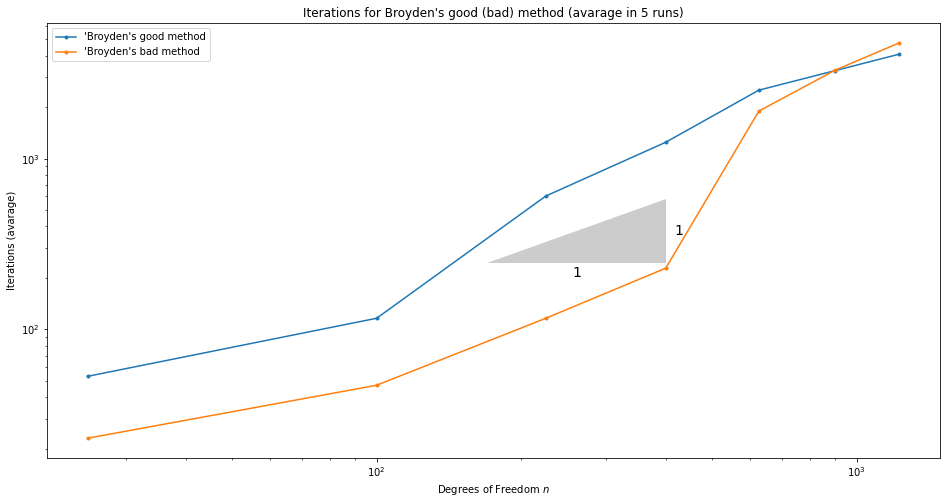

In [24]:
# observations in my trial, use them in case you clear the results from the last cell
# its_broyden1 = [53.0, 116.0, 603.0, 1246.0, 2515.0, 3272.0, 4085.0]
# its_broyden2 = [23.0, 47.0, 116.0, 228.0, 1896.0, 3287.0, 4759.0]

# Degree of Freedoms
ns = [25, 100, 225, 400, 625, 900, 1225]

fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.loglog(ns, its_broyden1, '.-', label="'Broyden's good method")
ax.loglog(ns, its_broyden2, '.-', label="'Broyden's bad method")
ax.set_title("Iterations for Broyden's good (bad) method (avarage in 5 runs)")
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Iterations (avarage)')
annotation.slope_marker((1.7e2, 2.45e2), (1, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.legend()

Through the log-log plot, we could conclude that though the complexity of iterations used for  Broyden's good (bad) method are not strictly proportional to some order of $n$, but it's (very) roughly about $O(n)$ in this small scale of $n$ s we have experimented.

# Question B4

In the lectures we have seen the importance of providing gradient information to the nonlinear solver algorithms. The derivative (Jacobian matrix) for the function ${\mathbf F}(\mathbf u)$ is given by

$$
  \frac{\partial {\mathbf F}({\mathbf u})}{\partial {\mathbf u}} = \alpha\underline{\mathbf K} + \underline{\mathbf I} +  \underline{\textbf{diag}}\left(\frac{1}{1+{\mathbf u}^2}\right)
$$

where $\underline{\textbf{diag}}\left( \frac{1}{1+{\mathbf u}^2} \right)$ is the diagonal matrix with the values $1/(1+u_i^2)$ along the main diagonal, where $u_i$ are the components of $\mathbf u$ (hint: use `scipy.sparse.diags(1/(1+u**2), format='csr')`).


Moreover, we can derive that the vector function ${\mathbf F}(\mathbf u)$ is itself the derivative of a scalar function $f(\mathbf u)$

$$
  f({\mathbf u}) = \tfrac 12 \alpha{\mathbf u^T} \underline{\mathbf K} {\mathbf u} 
  + \tfrac 12  {\mathbf u^T} {\mathbf u}
  +  {\mathbf u^T} \arctan({\mathbf u}) 
  - \tfrac 12 \sum_{i=1}^n \log(u_i^2+1)
  - {\mathbf u^T} {\mathbf s}
$$

so that we can formulate the root-finding problem $\mathbf{F}(\mathbf{u})=\mathbf{0}$ as minimisation problem for $f$ with Jacobian (of f):

$$
  f'(\mathbf{u}) = \frac{\partial {\mathbf f}({\mathbf u})}{\partial {\mathbf u}} = {\mathbf F}({\mathbf u}) = \alpha\underline{\mathbf K} {\mathbf u}
  +  {\mathbf u}
  +  \arctan(\mathbf{u})
  - {\mathbf s}
$$

and Hessian:

$$
  f''(\mathbf{u}) = \frac{\partial^2 {\mathbf f}({\mathbf u})}{\partial {\mathbf u}^2} = {\mathbf F'}({\mathbf u})  = \frac{\partial {\mathbf F}({\mathbf u})}{\partial {\mathbf u}} = \alpha\underline{\mathbf K} + \underline{\mathbf I} +  \underline{\textbf{diag}}\left(\frac{1}{1+{\mathbf u}^2}\right)
$$


* What mathematical property can you derive for the Hessian matrix $f''(\mathbf{u})$ and what consequence does this have for the optimisation problem?

## Answer for B4

Property: <br>
The Hessian matrix $f''(\mathbf{u})$ is Symmetric Positive Definite (SPD), independent of $\mathbf{u}$.
Or equivalently, $\,f''$ is SPD in $\mathbb{R}^n$ for any Degrees of Freedom $n$.
<br>
<br>
Proof:
<br>
1) In question **B1** we have proved that $\forall \, c \gt 0,\, \underline{\mathbf K} + c \underline{\mathbf I}$ is SPD, with the same reason $\forall \, \alpha \gt 0,\, \alpha \underline{\mathbf K} + \underline{\mathbf I}$ is SPD.
<br>
2) we can see that
$$
\begin{aligned}
\forall  {\bf v}\in{\mathbb{R}}^n,\text{except } \;{\bf v}&=0 \\
{\bf v}^T \underline{\textbf{diag}}\left(\frac{1}{1+{\mathbf u}^2}\right)
{\bf v} &= {{\bf v}}^T \left(\left(1+{\mathbf u}^2\right) {\bf v}\right)\\
&\gt 0
\end{aligned}
$$

independent of choose of $\mathbf u$. Thus, $\underline{\textbf{diag}}\left(\frac{1}{1+{\mathbf u}^2}\right)$ is SPD.
<br>
3) from 1) and 2), we can get 
$$
  f''(\mathbf{u}) = \left(\alpha\underline{\mathbf K} + \underline{\mathbf I}\right) +  \underline{\textbf{diag}}\left(\frac{1}{1+{\mathbf u}^2}\right)
$$

is the summation of two SPD Matrices, so $f''(\mathbf{u})$ is also SPD, $\forall \; \mathbf{u} \in \mathbb{R}^n$.
<br>
<br>
<u>The consequence for the optimisation problem</u>: <br> <br>
1) As the Hessian matrix $f''$ being SPD in $\mathbb{R}^n$, then from theorem in lecture-6:<br>
* "functions with a convex domain which are twice continuously differentiable are convex if and only if the Hessian is Positive Semidefinite in the interior of its domain." <br> 

as well as the definition of a function being **strictly convex**, it's sufficient to say that $f$ is **strictly convex** in the region $\mathbb{R}^n$. <br><br>
2) For some point 
<br>
<br>
$$
{\bf x}^* \in \mathbb{R}^n, \, f'({\bf x}^*)={\bf 0} \, \implies \; {\bf x}^* \text{ is a strict local minimum.}
$$
<br>
<br>
because the Hessian at some point $f''({\bf x}^*)$ is always Symmetric Positive Definite (SPD).
<br><br>

3) We also recall the following theorem from lecture-6:<br>
* "Any local minimum of a convex function is a global minimum. If the function is **strictly convex** (this means the interpolated values along a line are strictly above (not equal) to the function values), then the global minimum is attained in a single point only." <br>
<br>

***Conclusion***: <br>
Combine 1), 2) and 3), we can conclude that if there  $\exists \; {\bf x}^* \in \mathbb{R}^n$ , s.t $f'({\bf x}^*) = \mathbf F({\bf x}^*) = \bf{0}$,  then $f$ attains its **<font color=#FF0000> global minimum </font>** for $\mathbb{R}^n$ in this single point ${\bf x}^*$ only.


* Implement the python functions `f(u)`, and `hess(u)` which take the numerical solution $\mathbf{u}$ and return respectively the function value $f(\mathbf{u})$, and the Hessian $f''(\mathbf{u})$ as a scipy `csr_matrix`. 
Test that indeed `F(u)` is the derivative of `f(u)`, and that `hess(u)` is the derivative of `F(u)`. For this you may use the `taylor_test` code from lecture 4, but you will have to adjust it to make it work with csr matrices to test `hess(u)`.

According to the fomulas given in this question, we implement `f(u)` and `hess(u)` as following (Note `F(u)` and`S(x, y)` is the same as in Question B3):

In [25]:
def f(u):
    return 1/2 * (alpha * u.T @ K @ u + u.T @ u) + u.T @ np.arctan(u) - 1/2 * np.sum(np.log(u**2 + 1)) - u.T @ s

def hess(u):
    H = sp.diags(1/(1+u**2), format='csr')
    return alpha * K + sp.eye(n) + H

To check that indeed `F(u)` is the derivative of `f(u)`, and that `hess(u)` is the derivative of `F(u)`, we need the 
**taylor_test** method.

We define the Taylor residual (of order 2):

$$
  r({\bf h}) = f({\bf x} + {\bf h}) - f({\bf x}) - f'({\bf x})\cdot{\bf h}
$$
By Taylor expansion, we know $|r({\bf h})| \leq C\|{\bf h}\|^2$. <br> <br>
So if we have correctly derive a function $\mathbf{F}({\bf x})$ that computes the derivative $f'({\bf x})$, and we use this to compute $r({\bf h})$, we should have

$$
\begin{aligned}
|r({\bf h})| &\leq C\|{\bf h}\|^2\\
\left|f({\bf x} + {\bf h}) - f({\bf x}) - \mathbf{F}({\bf x})\cdot{\bf h} \right| &\leq C\|{\bf h}\|^2\;\;\text{ for small enough }{\bf h}  
\end{aligned}
$$
<br>
<br>
One problem with these sorts of tests is that we don't necessarily know what a small enough ${\bf h}$ is before this assymptotic behaviour becomes clear. We could consider a series of 

$$
  \newcommand\fac{\mathcal{F}}
  {\bf h}_k= \frac{{\bf h}_0}{\fac^k},
$$

where we divide $h_k$ by a factor of $\fac$ (usually $\fac=2$) each time. It is then possible to show that

$$
  \lim_{k\to\infty} \frac{r({\bf h}_k)}{r({\bf h}_{k+1})} \geq \fac^2
$$

If we take $\log$ of this series, we get

$$
  \lim_{k\to\infty} \frac{\log\left(\frac{r({\bf h}_k)}{r({\bf h}_{k+1})}\right)}{\log(\fac)} \geq 2
$$

We should keep dividing by a factor of $\fac$ until it reaches 2. We typically allow for some round off error and allow a value close to 2.

<br>
For the implementation of this method, we borrow the `taylor_test` code from lecture-4, we adjusted it a bit to make it work with csr matrices to test `hess(u)`, and here we take $\fac = 2$.

In [26]:
# borrow from lecture-4
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""

    h = h0.copy()
    residuals = []
    hnorms = []
    # these two stay the same, so we can compute them outside the loop:
    dfdx = grad_f(x)
    fx = f(x)
    
    for i in range(max_iter):
        # we altered the original code "np.sum(dfdx * h)" of this line to "dfdx @ h"
        # because the dimensional multiplication dfdx * h 
        # does not work for dfdx = Hessian (shape(n, n)) with fx = F(x) (shape (n, 1))
        r = f(x + h) - fx - dfdx @ h 
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0, max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((3/2 * hnorms[-1], residuals[-1]), (2, 1), invert=False, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

Apply the **Taylor test** to test that `F(u)` is the derivative of `f(u)`, on a grid of $50 \times 50$:

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.99958844 1.999789   1.99989685 1.99994962 1.9999752  1.9999877
 1.99999388 1.99999695 1.99999848 1.99999924 1.99999962 1.99999982
 1.9999999  2.00000013 2.00000003 2.00000155 2.00001178 2.00002905
 2.00016774]


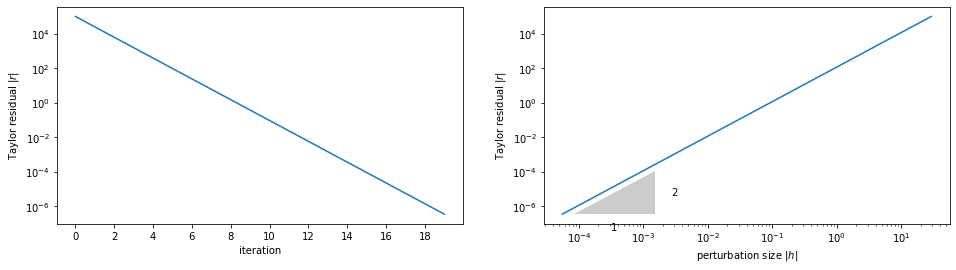

In [29]:
# we test the derivative F of f for mesh size of 60 * 60
nx = 50
K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
n = nx**2
s = s_function(xi, yi)

# the u0 should be random choosed, as long as it's a valid derivative in the whole region.
u0 = np.random.random(n)

# the perturbation h0 can also be random choosed, as long as it's getting smaller and smaller.
h0 = np.random.random(n)

taylor_test(f, F, u0, h0)

Apply the **Taylor test** to test that `hess(u)` is the derivative of `F(u)`, on a grid of $60 \times 60$:

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.95108559 2.00957036 2.01554778 2.01059382 2.00600459 2.00317874
 2.00163338 2.00082767 2.00041658 2.00020897 2.00010457 2.00005212
 2.00002559 2.00000946 1.99999212 1.99996016 1.99968241 1.99898418
 1.97687694]


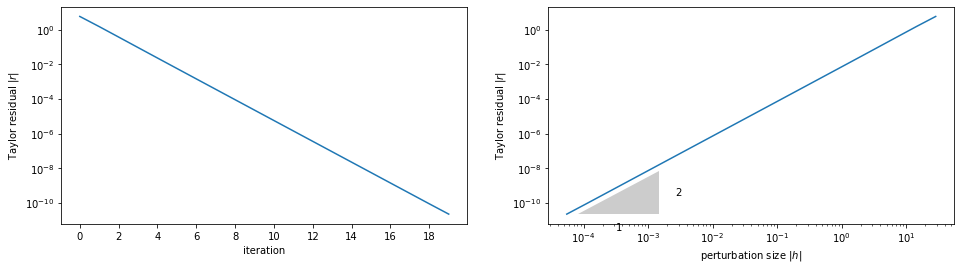

In [30]:
# we test the derivative hess of F for mesh size of 60 * 60
nx = 50
K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
n = nx**2
s = s_function(xi, yi)

# the u0 should be random choosed, as long as it's a valid derivative in the whole region.
u0 = np.random.random(n)

# the perturbation h0 can also be random choosed, as long as it's getting smaller and smaller.
h0 = np.random.random(n)

taylor_test(F, hess, u0, h0)

If we omit some round-off error, we can conclude that the function `F(u)` is indeed the derivative of `f(u)`, and that `hess(u)` is indeed the derivative of `F(u)`, as $$ \frac{\log\left(\frac{r({\bf h}_k)}{r({\bf h}_{k+1})}\right)}{\log(2)}$$ is getting close to 2.

* Solve the minimisation problem, finding the minimum of $f(\mathbf{u})$ using [`scipy.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):

```python
   result = scipy.optimize.minimize(f, u0, jac=F, method='bfgs', options={'gtol': 1e-5})
```

for a range of resolutions: hopefully a slightly larger range than in the question B4, but again limit the range to what can be solved in a few minutes. Again carefully inspect the `result` dictionary to ensure the solve has succeeded. To provide Hessian information (for those algorithms that use it), use the `hessp` argument to provide the function

```python
   def hessp(u, p):
        return hess(u) @ p
```

that performs the matrix-vector multiplication of the matrix returned by the function `hess(u)` from the previous question, and the provided vector (numpy array) `p`. Compare the required number of iterations for the methods `bfgs`, `l-bfgs-b`, and `trust-ncg`. To allow for a fair comparison use the same absolute gradient tolerance:

$$
  \| {\bf f}'({\bf u} \| \lt \varepsilon_{\text{abs}}=10^{-5}
$$

Note: with `l-bfgs-b` you will have to provide `'ftol': 0.` in addition to `'gtol': 1e-5` to avoid it sometimes stopping early based on a different stopping criterium:

```python
   result = scipy.minimize(f, u0, jac=F, method='l-bfgs-b', options={'ftol': 0., 'gtol': 1e-5})
```

Can you explain the difference in performance using what you know about the differences between the algorithms?

---

Define the `hessp` argument for use:

In [31]:
def hessp(u, p):
    return hess(u) @ p

Next we will solving the minimisation problem, finding the minimum of $f(\bf u)$ with three methods `bfgs`, `l-bfgs-b`, and `trust-ncg`. We choose a series of grid size: $5 \times 5, 10 \times 10, \, 20 \times 20, \, 40 \times 40, \, 60 \times 60, \, 80 \times 80 \, \text{and} \, 100 \times 100$, with the corresponding Degrees of Freedom $n$ is $25, 100, 400, 1600, 3600, 6400 \,\text{and}\, 10000$.  <br><br>
We will record the iteration used and compute the RMS error of our solution (w.r.t the exact solution `u(x, y)`) in each run. Also, we record the function evaluations of function `f`, `F` and `hess` for further analysis.

In [32]:
# the array of mesh sizes we use
nxs = [5, 10, 20, 40, 60, 80, 100]
ns =[]

# some arrays to store RMS errors for each method
RMS_bfgs =[]
RMS_l_bfgs_b =[]
RMS_trust_ncg =[]

# some arrays to store the iterations for each method use.
its_bfgs =[]
its_l_bfgs_b =[]
its_trust_ncg =[]

# array to store the function evaluations (f)
nfev_bfgs =[]
nfev_l_bfgs_b =[]
nfev_trust_ncg =[]

# array to store the Jocobian evaluations (F)
njev_bfgs =[]
njev_l_bfgs_b =[]
njev_trust_ncg =[]

#array to store Hessian evaluations for trust_ncg 
nhev_trust_ncg =[]

We run 5 times with `l-bfgs-b` and `trust-ncg`, taking their average results.

In [33]:
for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    n = nx**2
    ns.append(n)
    s = s_function(xi, yi)
    
    # just set a casual initial guess, u0 = 0
    u0 = np.zeros(n)
    
    # some parameters to record features
    res = 0
    success_times = 0
    its = 0
    nfev = 0
    njev = 0
    # run 5 times with l-bfgs-b method, and take the average iterations and RMS error 
    while(success_times < 5):
        result = sop.minimize(f, u0, jac=F, method='l-bfgs-b', options={'ftol': 0., 'gtol': 1e-5, 'disp': False})
        if(result.success):
            success_times += 1
            its += result.nit
            nfev += result.nfev
            njev += result.njev
            res += la.norm(u_exact(xi, yi) - result.x)/ n
    
    its_l_bfgs_b.append(its / 5)
    nfev_l_bfgs_b.append(nfev / 5)
    njev_l_bfgs_b.append(njev / 5)
    RMS_l_bfgs_b.append(res / 5)
    
    # some parameters to record features
    res = 0
    success_times = 0
    its = 0
    nfev = 0
    njev = 0
    nhev = 0
    # run 5 times with trust-ncg method, and take the average iterations and RMS error     
    while(success_times < 5):
        result = sop.minimize(f, u0, jac=F, hessp = hessp, method='trust-ncg', options={'gtol': 1e-5, 'disp': False})
        if(result.success):
            success_times += 1
            its += result.nit
            nfev += result.nfev
            njev += result.njev
            nhev += result.nhev
            res += la.norm(u_exact(xi, yi) - result.x)/ n
    
    its_trust_ncg.append(its / 5)
    nfev_trust_ncg.append(nfev / 5)
    njev_trust_ncg.append(njev / 5)
    nhev_trust_ncg.append(nhev / 5)
    RMS_trust_ncg.append(res / 5)   

The `BFGS` method infact takes a huge amount of time for a grid over $60 \times 60$ in this question, so we just run one time for each size of grid. **Note: Do not try to run this cell if time is limited, it takes me half an hour.**

In [88]:
for nx in nxs:
    K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
    n = nx**2
    s = s_function(xi, yi)
    
    # just set a casual initial guess, u0 = 0
    u0 = np.zeros(n)
    
    # run 1 time with bfgs method, as it is too time costy, and take the average iterations and RMS error 
    result = sop.minimize(f, u0, jac=F, method='bfgs', options={'gtol': 1e-5, 'disp': False})
    its = result.nit
    nfev = result.nfev
    njev = result.njev
    res = la.norm(u_exact(xi, yi) - result.x)/ n
    
    its_bfgs.append(its)
    nfev_bfgs.append(nfev)
    njev_bfgs.append(njev)
    RMS_bfgs.append(res)

The results by my run is stored in this cell, in case you clear (restart) the kernel:

In [119]:
# RMS_bfgs = [0.10383446911145704, 0.017003595598044624, 0.0034543189456439916, 0.0007792482823381769, 0.00033487008919921846, 0.00018525304636346496, 0.0001173906070791042]
# its_bfgs = [12, 53, 155, 354, 436, 496, 525]
# nfev_bfgs = [16, 72, 196, 396, 472, 517, 538]
# njev_bfgs = [16, 72, 196, 396, 472, 517, 538]

In [124]:
print("Degrees of Freedom: ", ns)
print("RMS error for BFGS: ", RMS_bfgs)
print("RMS error for L-BFGS-B: ", RMS_l_bfgs_b)
print("RMS error for trust-ncg: ", RMS_trust_ncg)

Degrees of Freedom:  [25, 100, 400, 1600, 3600, 6400, 10000]
RMS error for BFGS:  [0.10383446911145704, 0.017003595598044624, 0.0034543189456439916, 0.0007792482823381769, 0.00033487008919921846, 0.00018525304636346496, 0.0001173906070791042]
RMS error for L-BFGS-B:  [0.10324770003596354, 0.017003611210693523, 0.003454315606015705, 0.0007792503703009948, 0.00033487115137469006, 0.00018525278854252577, 0.00011739118359699076]
RMS error for trust-ncg:  [0.10324767919894914, 0.0170035949196654, 0.003454318678840507, 0.0007792482376949746, 0.0003348700928081443, 0.00018525304943588244, 0.00011739060881934418]


We see the RMS Error for our solutions get by bfgs, l-bfgs-b and trust-ncg method decrease as the mesh becomes finer, which means our numerical solution is approaching the given exact solution $u(x, y)$.<br>
Moreover, the RMS error vector for those three methods is almost the same, which means they almost got the same solution.<br>
<br>
Next, Let's make a log-log plot for the iterations used for those three method:

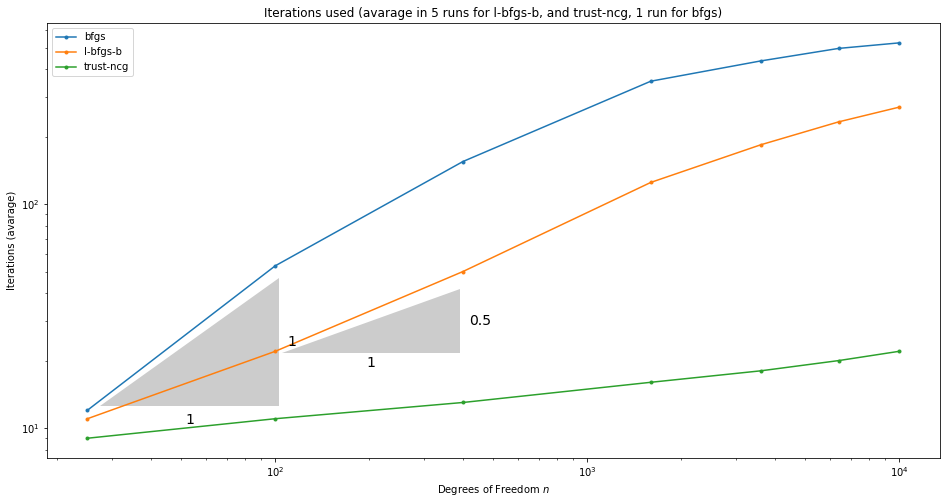

In [169]:
# its_bfgs = [12, 53, 155, 354, 436, 496, 525]
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.loglog(ns, its_bfgs, '.-', label="bfgs")
ax.loglog(ns, its_l_bfgs_b, '.-', label="l-bfgs-b")
ax.loglog(ns, its_trust_ncg, '.-', label="trust-ncg")
ax.set_title("Iterations used (avarage in 5 runs for l-bfgs-b, and trust-ncg, 1 run for bfgs)")
ax.set_xlabel('Degrees of Freedom $n$')
ax.set_ylabel('Iterations (avarage)')
annotation.slope_marker((1.05e2, 2.17e1), (0.5, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((2.75e1, 1.25e1), (1, 1), ax=ax,
                        size_frac=.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.legend()

From the log-log plot, we can observe that the `trust-ncg` method uses the least iterations comparing to other two methods. The `l-bfgs-s` uses more iterations than `trust-ncg` but less than `bfgs`.
Also, we can observe that the increasing rate of iterations used by `bfgs` and `l-bfgs-s` are getting smaller as the degrees of freedom $n$ increases.<br>
<br>
Let's observe some other paramters, involving the function evaluation used for those methods:

In [125]:
print("Degrees of Freedom: ", ns)
print('-------------------------------------------------------------------------------------')
print("Iteration used for bfgs:", its_bfgs)
print("f evaluations for bfgs:", nfev_bfgs)
print("Jacobian evaluations for bfgs:", njev_bfgs)
print('-------------------------------------------------------------------------------------')
print("Iteration used for l-bfgs-b:", its_l_bfgs_b)
print("f evaluations for l-bfgs-b:", nfev_l_bfgs_b)
print("Jacobian evaluations for l-bfgs-b:", njev_l_bfgs_b)
print('-------------------------------------------------------------------------------------')
print("Iteration used for trust-ncg:", its_trust_ncg)
print("f evaluations for trust-ncg:", nfev_trust_ncg)
print("Jacobian evaluations for trust-ncg:", njev_trust_ncg)
print("Hessian evaluations for trust-ncg:",nhev_trust_ncg)

Degrees of Freedom:  [25, 100, 400, 1600, 3600, 6400, 10000]
-------------------------------------------------------------------------------------
Iteration used for bfgs: [12, 53, 155, 354, 436, 496, 525]
f evaluations for bfgs: [16, 72, 196, 396, 472, 517, 538]
Jacobian evaluations for bfgs: [16, 72, 196, 396, 472, 517, 538]
-------------------------------------------------------------------------------------
Iteration used for l-bfgs-b: [11.0, 22.0, 50.0, 125.0, 184.0, 233.0, 271.0]
f evaluations for l-bfgs-b: [12.0, 24.0, 57.0, 133.0, 193.0, 244.0, 283.0]
Jacobian evaluations for l-bfgs-b: [12.0, 24.0, 57.0, 133.0, 193.0, 244.0, 283.0]
-------------------------------------------------------------------------------------
Iteration used for trust-ncg: [9.0, 11.0, 13.0, 16.0, 18.0, 20.0, 22.0]
f evaluations for trust-ncg: [10.0, 12.0, 14.0, 17.0, 19.0, 21.0, 23.0]
Jacobian evaluations for trust-ncg: [10.0, 12.0, 14.0, 17.0, 19.0, 21.0, 23.0]
Hessian evaluations for trust-ncg: [27.0, 5

### Some differences

1) we could see that the number of Iterations for each method is almost equal to the number of $\mathbf f$ evaluations and the number of Jacobian evaluations.<br> 

2) The number of iterations (function evaluations) of `l-bfgs-b` is less than `bfgs`, the possible reason is that `l-bfgs-b` borrows ideas from the trust region methods, adding some constraints when updating, which prevents $x$ goes too far in a wrong direction.<br>

3) The number of iterations of `trust_ncg` is much less compared to the other two methods, and also has a very small increasing rate. Because in every step, it updates  ${\bf x}^{(i+1)} = {\bf x}^{(i)} + {\bf p}$ with ${\bf H}({\bf x}^{(i)}) {\bf p} = -{\bf F}({\bf x}^{(i)})$ given an exact Hessian matrix ${\bf H}$,  which have a strict **quadratic** convergence to the stationary point. However, the Hessian evaluations it needs is quite large, as in the Trust Region Methods, it modifies the Hessian $$
  \mathbf H({\bf x}_0) \to \mathbf H({\bf x}_0) + \mu\underline{\mathbf I}
$$ with such $\mu$ needs several evaluations of ${\bf H}$ with in the region  $B({\bf x}_0, \delta)$ to find.

# Question B5

Finally we introduce a spatially varying coefficient $m(x, y)$ in front of the non-linear term:
    
$$
    -\alpha\frac{\partial^2 u(x,y)}{\partial x^2} - \alpha\frac{\partial^2 u(x,y)}{\partial y^2} +  u(x,y) +  m(x, y) \arctan(u(x,y)) = s(x,y)
$$

so that the nonlinear discretised system changes to:
    
$$   
{\mathbf F}({\mathbf u}, {\mathbf m}) = \alpha\underline{\mathbf K} {\mathbf u} +  {\mathbf u} + {\mathbf m}\arctan({\mathbf u}) - {\mathbf s} = {\mathbf 0}
$$

where $\mathbf{m}$ is the vector of values of $m(x, y)$ at the grid points, and ${\mathbf m}\arctan({\mathbf u})$ is simply the element-wise product of ${\mathbf m}$ and $\arctan({\mathbf u})$.

As before we are given a function $f({\mathbf u}, {\mathbf m})$, such that $\frac{\partial f({\mathbf u},{\mathbf m})}{\partial {\mathbf u}} = F({\mathbf u}, {\mathbf m})$:

$$
  f({\mathbf u}) = \tfrac 12 \alpha{\mathbf u^T} \underline{\mathbf K} {\mathbf u} 
  + \tfrac 12  {\mathbf u^T} {\mathbf u}
  + \sum_{i=1}^n m_i\left[ u_i \arctan(u_i) - \tfrac 12 \log(u_i^2+1)\right]
  - {\mathbf u^T} {\mathbf s}
$$

and its Hessian (in $\mathbf u$):

$$
  \frac{\partial^2 {\mathbf f}({\mathbf u}, \mathbf{m})}{\partial {\mathbf u}^2}
  = \frac{\partial {\mathbf F}({\mathbf u}, \mathbf{m})}{\partial {\mathbf u}}
  = \alpha\underline{\mathbf K} + \underline{\mathbf I} +  \underline{\textbf{diag}}\left(\frac{\mathbf{m}}{1+{\mathbf u}^2}\right)
$$

Imagine we apply this equation to some physical process, say a reaction diffusion system, where we know the source term $s(x, y)$ and we can observe the field $u(x,y)$ through measurement. We would like to know for what values of $\mathbf{m}$ (the "model parameters") our numerical prediction $\mathbf{u}$ is closest to the measured observation $\mathbf{u_{\text{obs}}}$. Since there might be multiple values of $\mathbf m$ for which $\mathbf u$ is close to $\mathbf u_{\text{obs}}$, including many "noisy" solutions at the grid level, we use a priori knowledge to require that the optimal choice of $\mathbf m$ should be smooth.

Thus we formulate this as a PDE-constrained optimisation problem based on a functional 

$$
  J(\mathbf{u}, \mathbf{m}) = \tfrac 12 \left(\mathbf{u}-\mathbf{u_{\text{obs}}}\right)^T \left(\mathbf{u}-\mathbf{u_{\text{obs}}}\right) + \tfrac 12\gamma 
  {\mathbf m^T} \underline{\mathbf K} {\mathbf m} 
$$

where the first term represents the mismatch between $\mathbf u$ and $\mathbf u_{\text{obs}}$. The second term, which uses the same discrete Laplace operator $\underline{\mathbf K}$ as before,
is only small for smooth solutions, thus penalizing noisy solutions. It is weighted by a scalar $\gamma$, where you may use the value of $\gamma=10^{-4}$.

To find the optimal $\mathbf m$ we minimize $J(\mathbf{u}, \mathbf{m})$
subject to the constraint

$$
  \mathbf{F}(\mathbf{u}, \mathbf{m}) = \mathbf{0}.
$$

As usual, we also define the reduced functional:

$$
  \hat J(\mathbf{m}) = J(\mathbf{u}(\mathbf{m}), \mathbf{m})
$$

where $\mathbf{u}(\mathbf{m})$ is the unique solution $\mathbf{u}$ that satisfies the constraint for the given values of $\mathbf m$.

* Describe mathematically the steps to calculate the derivative 
$$\frac{d\hat{J}(\mathbf{m})}{d\mathbf{m}}$$ using the (discrete) adjoint method. Work out the various derivatives of $J(u, m)$ and $F(u, m)$ that occur in your equations.

## Answer for B5

If we assume that $u(m)$ is a solution of $\mathbf{F} (u,m)=0$ then the Lagrangian simplifies to

$$
  \mathcal{L}(u(m), m, \lambda) = J(u(m), m) + \lambda \, \mathbf{F}(u(m), m) = J(u(m), m) = \hat J(m)
$$

We can now compute the total derivative of $\mathcal{L}(u(m), m, \lambda)$ and therefore of the reduced functional $\hat J(m)$, with respect to $m$:

$$
  \frac{d\hat J(m)}{dm} = \frac{d\mathcal{L}(u(m), m, \lambda)}{dm} = \left.\frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u}\right|_{u=u(m)} \frac{du(m)}{dm}
    + \left.\frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m}\right|_{u=u(m)}
$$

In this equation if we choose $\lambda$ to satisfy the adjoint equation:

$$
  \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u} = \frac{\partial J(u,m)}{\partial u} - \lambda\cdot \frac{\partial \mathbf{F}(u, m)}{\partial u} = 0 
$$

Then we could get rid of the $\frac{du(m)}{dm}$, and our $\frac{d\hat J(m)}{dm}$ would simply become:
$$
  \frac{d\hat J(m)}{dm} = \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m} = \frac{\partial J(u,m)}{\partial m} - \lambda\cdot \frac{\partial \mathbf{F}(u, m)}{\partial m}
$$

In this question, we have $\mathbf{F}$ and $J$ with their explicit form:
<br>
<br>
$$   
{\mathbf F}({\mathbf u}, {\mathbf m}) = \alpha\underline{\mathbf K} {\mathbf u} +  {\mathbf u} + {\mathbf m}\arctan({\mathbf u}) - {\mathbf s} = {\mathbf 0}\\
 J(\mathbf{u}, \mathbf{m}) = \tfrac 12 \left(\mathbf{u}-\mathbf{u_{\text{obs}}}\right)^T \left(\mathbf{u}-\mathbf{u_{\text{obs}}}\right) + \tfrac 12\gamma \;
  {\mathbf m^T} \underline{\mathbf K} {\mathbf m} 
$$

Now we can compute 

$$ \left\{
\begin{aligned}
\frac{\partial \mathbf F}{\partial u} &= \alpha \, \underline{\mathbf K} + \underline{\mathbf I} + \underline{\textbf{diag}}\left(\frac{\mathbf{m}}{1+{\mathbf u}^2}\right)\\
\frac{\partial \mathbf F}{\partial m} &= \underline{\textbf{diag}}\left(\arctan\left(\mathbf u\right)\right)\\
\frac{\partial J}{\partial u} &= \left(\mathbf u - \mathbf{u_{\text{obs}}}\right)^T\\
\frac{\partial J}{\partial m} &= \left(\gamma \, \underline{\mathbf K} \mathbf{m}\right)^T
\end{aligned}
\right.
$$
<br>
<br>
Thus, we could compute $d\hat f(m)/dm$ for any $m$ in three steps:

1) Solve the PDE constraint $\mathbf F(u, m)=0$ to obtain $u=u(m)$

2) Solve the adjoint equation using $m$ and $u(m)$ for $\lambda$, such that $\frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u}=0$, in this question, we have (n is the degree of Freedom)
<br>
<br>
$$
  \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u} = \frac{\partial J(u,m)}{\partial u} - \lambda\cdot \frac{\partial \mathbf F(u, m)}{\partial u} = 0\\
\downarrow\\
  \underset{\bf 1\times n}{\frac{\partial J({\bf u}, {\bf m})}{\partial{\bf u}}} - \underset{\bf 1\times n}{\lambda^T} 
  \underset{\bf n\times n}{\frac{\partial \mathbf F({\bf u}, {\bf m})}{\partial{\bf u}}} = 0 \\
  \downarrow\\
  \underset{\bf n\times n}{\left(\frac{\partial \mathbf F({\bf u}, {\bf m})}{\partial {\bf u}}\right)^T}
  \underset{\bf n\times 1}{\lambda} = \underset{\bf 1\times n}{\left(\frac{\partial J({\bf u},{\bf m})}{\partial {\bf u}}\right)^T}
$$

As we have computed the partial derivatives above, we could observe that indeed $\frac{\partial \mathbf F({\bf u}, {\bf m})}{\partial{\bf u}}$ is symmetric, thus we can have this further simplified form:
<br>
<br>
$$
  \left[\alpha \, \underline{\mathbf K} + \underline{\mathbf I} + \underline{\textbf{diag}}\left(\frac{\mathbf{m}}{1+{\mathbf u}^2}\right)\right] \cdot \mathbf{\lambda} = \mathbf u - \mathbf{u_{\text{obs}}}
$$

3) Then we could compute derivative of the reduced functional by

$$
\begin{aligned}
\underset{\bf 1\times n} {\frac{d\hat J(m)}{dm}}= \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m} &= \frac{\partial J(u,m)}{\partial m} - \lambda\cdot \frac{\partial \mathbf F(u, m)}{\partial m}\\
&= \underset{\bf 1\times n}{\frac{\partial \mathbf J({\bf u}, {\bf m})}{\partial {\bf m}}} -
\underset{\bf 1\times n}{\lambda^T} \underset{\bf n\times n}{\frac{\partial \mathbf F({\bf u},{\bf m})}{\partial {\bf m}}}
\end{aligned}
$$

because a $1 \times n$ divergence vector is equivalent to its transpose, a $n \times 1$ vector in `scipy` functions, so we could just evaluate:

$$
\begin{aligned}
\underset{\bf n\times 1} {\left(\frac{d\hat J(m)}{dm}\right)^T} &= \underset{\bf n\times 1}{\left(\frac{\partial \mathbf J({\bf u}, {\bf m})}{\partial {\bf m}}\right)^T} - \underset{\bf n\times n}{\left(\frac{\partial \mathbf F({\bf u},{\bf m})}{\partial {\bf m}}\right)^T} \underset{\bf n\times 1}{\lambda}\\
&= \gamma \, \underline{\mathbf K} \mathbf{m} - \underline{\textbf{diag}}\left(\arctan\left(\mathbf u\right)\right) \cdot \boldsymbol{\lambda}\\
&= \gamma \, \underline{\mathbf K} \mathbf{m} - \boldsymbol{\lambda} \arctan\left(\mathbf u\right) 
\end{aligned}
$$

after these three steps, we would have the total derivative of $\mathcal{L}(u(m), m, \lambda)$ and therefore of the reduced functional $\hat J(m)$, for a given $m$.

* Implement python functions `Jhat(m)`, that calculates the functional value $\hat{J}({\mathbf m})$,
and `grad_Jhat(m)`, that implements its derivative using the method from the previous question. Test whether the gradient is correct.

In [34]:
gamma = 1e-4

First we define `f`, `F`, `Hess` for this question:

In [35]:
def f(u):
    return 1/2 * (alpha * u.T @ K @ u + u.T @ u) + np.sum(m * ( np.arctan(u) * u \
           - 1/2 * np.log(u**2 + 1))) - u.T @ s   
def F(u):
    return alpha * K @ u + u + m * np.arctan(u) - s

def hess(u):
    H = sp.diags(m/(1+u**2), format='csr')
    return alpha * K + sp.eye(n) + H

def hessp(u, p):
    return hess(u) @ p

By the steps and mathematical formulas we have derived above, we code up the `Jhat` and `grad_Jhat` functions for a given 
input $m$.<br>
The reason why I state **global** for `m` and assign the argument `x` back to it is that, to enable those 
`f(u)` functions taking correct `m` s updated by the argument.

In [36]:
def Jhat(x):
    global m
    m = x
    # we should get u = u(m) by solving F(u, m) = 0 with a given m
    u = sop.root(F, u0, method='krylov', options={'disp': False, 'ftol': 1e-14, 'maxiter': 20000}).x
    # a global variable to monitor how close is the prediction to the observation
    global res
    res = u - u_obs
    return 1/2 * (res.T @ res + gamma * m.T @ K @ m)

def grad_Jhat(x):
    global m
    m = x
    # step one, we should get u = u(m) by solving F(u, m) = 0 with a given m
    u = sop.root(F, u0, method='krylov', options={'disp': False, 'ftol': 1e-14,'maxiter': 20000}).x
    # step two, solving lambda by the linear equation Hessian @ lambda = u - u_obs
    H = hess(u)
    lamda = spl.spsolve(H, u - u_obs)
    # step three, return df/dm = \partial J / \partial m - (\partial F / \partial m)  @ lambda
    return gamma * K @ m - lamda * np.arctan(u)

Next, we would apply the **taylor test** to show that `grad_Jhat` is indeed a valid gradient 
for `Jhat`, on a $25 \times 25$ grid, note we keep `s` the same source function in question B3, and also `u_obs` can be a random vector because our implementation should work for any source function and any observation data provided.

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.94344937 1.97172058 1.98588434 1.99295234 1.99647933 1.99824054
 1.9991205  1.99956029 1.99978018 1.99989017 1.99994408 1.99997361
 1.99995154 1.99988091 1.99937029 1.99765262 1.99397414 1.96164975
 2.04619591]


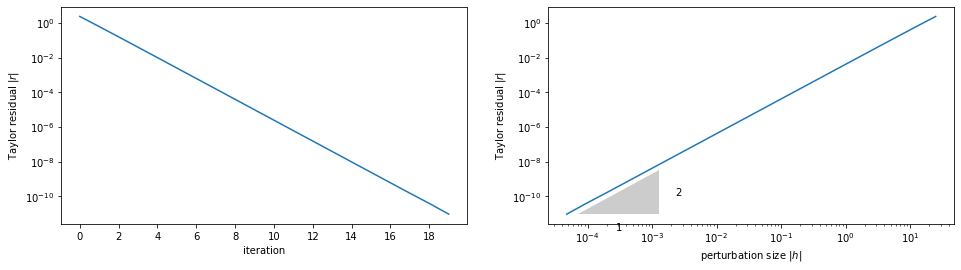

In [37]:
# create some constant parameters for a mesh size of 25 * 25.
nx = 25
K, xi, yi = laplace_matrix(nx, nx, Lx, Ly)
n = nx**2
s = s_function(xi, yi)
# a random observation
u_obs = np.random.random(n)
# the initial guess for iteration solvers
u0 = np.zeros(n)
# m should be a random point 
m = np.random.random(n)

# u = np.random.random(n)
# we take our original perturbation h0 being (1, 1, 1 .......)
h0 = np.ones(n)

taylor_test(Jhat, grad_Jhat, m, h0)

If we omit some round-off error, we can conclude that the function `grad_Jhat` we implemented is indeed the derivative of `Jhat`, as $$ \frac{\log\left(\frac{r({\bf h}_k)}{r({\bf h}_{k+1})}\right)}{\log(2)}$$ is getting close to 2.

*  Use this gradient information to solve the PDE-constrained optimisation problem. 
For testing purposes we can again setup a problem where we simply choose what the optimal $\mathbf m$ is. 
Consider the following choice of model parameters
$$
  m(x, y) = (x-0.5)^2 + (y-0.5)^2
$$
at the grid points in a vector $\mathbf{m^*}$. Using the source term
$$
  \mathbf{s} = \alpha\underline{\mathbf K} {\mathbf u^\ast} + {\mathbf u^\ast} + \mathbf{m^*}\arctan({\mathbf u^\ast})
$$
we can ensure that the PDE constraint $\mathbf{F}(\mathbf{u}, \mathbf{m}) = \mathbf{0}$ has the solution $\mathbf{u}=\mathbf{u^\ast}$ for any choice of $\mathbf{u^\ast}$, so that we can choose its values again to be the same analytical solution:
$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$
Using this choice of $\mathbf{s}$ and using the same $\mathbf{u^\ast}$ as the observation $\mathbf{u}_{\text{obs}}$, check that the code you wrote is able to retrieve the chosen values of $\mathbf{m^*}$. You do not need to repeat this for different resolutions, choose one resolution for your testing, say $n=25\times 25$.

Define the new source function $\bf s$ and $\bf {m^{\ast}}$ given in this question:

In [38]:
def m_ast(xi, yi):
    return (xi - 0.5) **2 + (yi - 0.5)**2
def s_function(xi, yi):
    return alpha * K @ u_obs + u_obs + m_ast(xi, yi) * np.arctan(u_obs)

We check that `grad_Jhat` is indeed a valid gradient 
for `Jhat` again, as the function `s` has been changed, , also we define $\bf u_{obs}$ as the 
$$
  u(x,y) = \cos(2\pi x) \cos(2\pi y)
$$ given before.

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.87912215 1.93782037 1.96832876 1.98398887 1.99194558 1.99595986
 1.9979766  1.99898746 1.99949351 1.9997467  1.99987335 1.99993675
 1.99996846 1.99998476 1.99999553 1.99999946 2.00005599 2.00008513
 2.00033145]


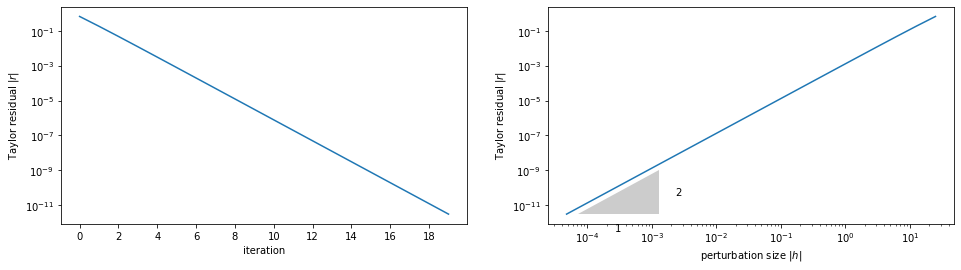

In [40]:
# assign s to the new source function
s = s_function(xi, yi)

# redefine f and F according to this new s-function
def f(u):
    return 1/2 * (alpha * u.T @ K @ u + u.T @ u) + np.sum(m * ( np.arctan(u) * u \
           - 1/2 * np.log(u**2 + 1))) - u.T @ s   
def F(u):
    return alpha * K @ u + u + m * np.arctan(u) - s

# define the observation vector u_obs
u_obs = u_exact(xi, yi)
# the initial guess for iteration solvers
u0 = np.zeros(n)
# m should be a random point 
m = np.random.random(n)

# we take our original perturbation h0 being (1, 1, 1 .......)
h0 = np.ones(n)

taylor_test(Jhat, grad_Jhat, m, h0)

We see our `grad_Jhat` still pass the taylor test, so now Let's use `Jhat` and `grad_Jhat` function to solve for the functional $J$, treating it as a single variable scalar function $\hat{J}({\mathbf m})$.

Now Let's treat this as a single-valuable non-linear optimization problem. <br>
To minimize $\hat{J}({\mathbf m})$, we use the **Truncated Newton Methods** here (the `TNC` method in `scipy.optimize.minimize`), note that the `L-BFGS-B` and `BFGS` would also give valid results here, but more time costy.

In [41]:
# setting up a initial guess of m for Jhat and grad_Jhat to use, can be random.
m0 = np.random.random(n)

In [42]:
gamma = 1e-4
# result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='L-BFGS-B', options={'ftol': 0, 'gtol': 1e-6, 'disp': True})
# result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='BFGS', options={'gtol': 1e-6, 'disp': True})
result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='TNC', options={'gtol': 1e-6, 'disp': True})

Observe our solution $\mathbf{m}$:

In [43]:
result.x

array([0.38298305, 0.37504642, 0.35988761, 0.33914182, 0.31499782,
       0.28997327, 0.26649311, 0.2464141 , 0.23066627, 0.21929313,
       0.21181078, 0.20761898, 0.20627769, 0.20762742, 0.21182762,
       0.21932024, 0.23070342, 0.2464557 , 0.26653808, 0.29002356,
       0.31503862, 0.33916627, 0.35989991, 0.37503597, 0.38296926,
       0.3750408 , 0.36740856, 0.35284978, 0.3329163 , 0.30972692,
       0.28568169, 0.26307581, 0.24369076, 0.22840808, 0.21730622,
       0.20994835, 0.20581507, 0.20448853, 0.20582228, 0.2099726 ,
       0.21733554, 0.22844951, 0.24373526, 0.26312772, 0.28572607,
       0.30976646, 0.33294412, 0.35286426, 0.36741381, 0.37503473,
       0.35989193, 0.35285356, 0.33942757, 0.32103402, 0.29963918,
       0.27741505, 0.25644813, 0.23831355, 0.22385787, 0.213205  ,
       0.20605744, 0.20199548, 0.20068259, 0.20200629, 0.20608066,
       0.21324086, 0.22390036, 0.23836366, 0.2564973 , 0.27746594,
       0.29967972, 0.32106826, 0.3394484 , 0.35286559, 0.35989

As well as $\mathbf{m^\ast}$:
$$
  m^\ast(x, y) = (x-0.5)^2 + (y-0.5)^2
$$

In [44]:
m_ast(xi, yi)

array([0.5       , 0.46006944, 0.42361111, 0.390625  , 0.36111111,
       0.33506944, 0.3125    , 0.29340278, 0.27777778, 0.265625  ,
       0.25694444, 0.25173611, 0.25      , 0.25173611, 0.25694444,
       0.265625  , 0.27777778, 0.29340278, 0.3125    , 0.33506944,
       0.36111111, 0.390625  , 0.42361111, 0.46006944, 0.5       ,
       0.46006944, 0.42013889, 0.38368056, 0.35069444, 0.32118056,
       0.29513889, 0.27256944, 0.25347222, 0.23784722, 0.22569444,
       0.21701389, 0.21180556, 0.21006944, 0.21180556, 0.21701389,
       0.22569444, 0.23784722, 0.25347222, 0.27256944, 0.29513889,
       0.32118056, 0.35069444, 0.38368056, 0.42013889, 0.46006944,
       0.42361111, 0.38368056, 0.34722222, 0.31423611, 0.28472222,
       0.25868056, 0.23611111, 0.21701389, 0.20138889, 0.18923611,
       0.18055556, 0.17534722, 0.17361111, 0.17534722, 0.18055556,
       0.18923611, 0.20138889, 0.21701389, 0.23611111, 0.25868056,
       0.28472222, 0.31423611, 0.34722222, 0.38368056, 0.42361

Let's check the $d_1$ norm of $\mathbf{m} - \mathbf{m^\ast}$:

In [45]:
np.sum(abs(result.x - m_ast(xi, yi)))

33.52544219330538

Also the $d_1$ norm of $\mathbf u - \mathbf {u_{\text{obs}}}$:

In [46]:
np.sum(res)

0.03336396203626385

We could see that they are not very close to each other, or say, our effect of retrieving is not that good, is this caused by we having a wrong methodology or maybe other reasons?<br>
Let's compute some values, note that our functional to minimize is  
$$\hat{J}(\mathbf{m}) = \tfrac 12 \left(\mathbf{u(\mathbf{m})}-\mathbf{u_{\text{obs}}}\right)^T \left(\mathbf{u(\mathbf{m})}-\mathbf{u_{\text{obs}}}\right) + \tfrac 12\gamma \;
  {\mathbf m^T} \underline{\mathbf K} {\mathbf m} 
$$

Now we have a $\gamma = 1e^{-4}$

In [47]:
m = m_ast(xi, yi)
print("Jhat for m_exact: ", Jhat(m_ast(xi, yi)))
print("1/2 gamma * m.T @ K @ m contribution: ", 1/2 * gamma * m.T @ K @ m)
print("1/2 (u - u_obs).T @ (u - u_obs) contribution", 1/2 * res @ res)
print("checking those two adding up to Jhat:", 1/2 * res @ res + 1/2 * gamma * m.T @ K @ m)

Jhat for m_exact:  0.019965277777777762
1/2 gamma * m.T @ K @ m contribution:  0.019965277777777762
1/2 (u - u_obs).T @ (u - u_obs) contribution 6.069766986569361e-29
checking those two adding up to Jhat: 0.019965277777777762


In [48]:
m = result.x
print("Jhat for m_optimize: ", Jhat(result.x))
print("1/2 gamma * m.T @ K @ m contribution: ", 1/2 * gamma * m.T @ K @ m)
print("1/2 (u - u_obs).T @ (u - u_obs) contribution", 1/2 * res @ res)
print("checking those two adding up to Jhat:", np.allclose(1/2 * res @ res + 1/2 * gamma * m.T @ K @ m, Jhat(result.x)))

Jhat for m_optimize:  0.008771644434936571
1/2 gamma * m.T @ K @ m contribution:  0.006322319614791118
1/2 (u - u_obs).T @ (u - u_obs) contribution 0.0024493248201454534
checking those two adding up to Jhat: True


From the results above we could see that the $\hat{J}(\mathbf{m^\ast})$ is even larger than the $\hat{J}(\mathbf{m})$ which is solution we get ! This is because the term $\tfrac 12\gamma \;
  {\mathbf m^T} \underline{\mathbf K} {\mathbf m}$ has too large contribution in the functional value compared to the term $\tfrac 12 \left(\mathbf{u(\mathbf{m})}-\mathbf{u_{\text{obs}}}\right)^T \left(\mathbf{u(\mathbf{m})}-\mathbf{u_{\text{obs}}}\right)$, which leads to the given $\mathbf{m^\ast}$ is actually not the optimum for the functional $\hat{J}(\mathbf{m})$ !

Let's choose a small $\gamma$ and see if this issue is fixed, say $\gamma = 1e^{-8}$

In [49]:
gamma = 1e-8

In [50]:
m = m_ast(xi, yi)
print("Jhat for m_exact: ", Jhat(m_ast(xi, yi)))
print("1/2 gamma * m.T @ K @ m contribution: ", 1/2 * gamma * m.T @ K @ m)
print("1/2 (u - u_obs).T @ (u - u_obs) contribution", 1/2 * res @ res)
print("checking those two adding up to Jhat:", 1/2 * res @ res + 1/2 * gamma * m.T @ K @ m)

Jhat for m_exact:  1.9965277777777767e-06
1/2 gamma * m.T @ K @ m contribution:  1.9965277777777767e-06
1/2 (u - u_obs).T @ (u - u_obs) contribution 6.069766986569361e-29
checking those two adding up to Jhat: 1.9965277777777767e-06


We can see now the contribution of the term $\tfrac 12\gamma \;
  {\mathbf m^T} \underline{\mathbf K} {\mathbf m}$ in the functional $\hat{J}(\mathbf{m})$ has been weakened.

Let's solve the optimization problem again:

In [73]:
# result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='L-BFGS-B', options={'ftol': 0, 'gtol': 1e-6, 'disp': True})
# result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='BFGS', options={'gtol': 1e-6, 'disp': True})
result = sop.minimize(Jhat, m0, jac=grad_Jhat, method='TNC', options={'gtol': 1e-6, 'disp': True})

Observe our solution $\mathbf{m}$:

In [74]:
result.x

array([ 0.49444562,  0.46844029,  0.41372679,  0.39159839,  0.35822699,
        0.31764881,  0.28943536,  0.27713699,  0.27428679,  0.26392343,
        0.25376246,  0.25216709,  0.24817481,  0.24971737,  0.25512689,
        0.26601978,  0.27251883,  0.27706473,  0.28800381,  0.32002833,
        0.35626641,  0.3869267 ,  0.42185151,  0.46368199,  0.49269371,
        0.45697674,  0.42942272,  0.37923633,  0.35561881,  0.32755941,
        0.29510648,  0.26986568,  0.254476  ,  0.24370308,  0.22972072,
        0.21916469,  0.21330553,  0.21361057,  0.21320908,  0.21965872,
        0.22991813,  0.24173017,  0.25236164,  0.26828022,  0.29693249,
        0.32520242,  0.35363168,  0.38576863,  0.42979901,  0.46252201,
        0.42384946,  0.38600485,  0.34765229,  0.31529335,  0.28571908,
        0.26273986,  0.24155752,  0.22193574,  0.20312729,  0.18831576,
        0.17985803,  0.17647443,  0.17436689,  0.1728229 ,  0.17997385,
        0.18826417,  0.20310762,  0.22149702,  0.24149519,  0.26

As well as $\mathbf{m^\ast}$:
$$
  m^\ast(x, y) = (x-0.5)^2 + (y-0.5)^2
$$

In [75]:
m_ast(xi, yi)

array([0.5       , 0.46006944, 0.42361111, 0.390625  , 0.36111111,
       0.33506944, 0.3125    , 0.29340278, 0.27777778, 0.265625  ,
       0.25694444, 0.25173611, 0.25      , 0.25173611, 0.25694444,
       0.265625  , 0.27777778, 0.29340278, 0.3125    , 0.33506944,
       0.36111111, 0.390625  , 0.42361111, 0.46006944, 0.5       ,
       0.46006944, 0.42013889, 0.38368056, 0.35069444, 0.32118056,
       0.29513889, 0.27256944, 0.25347222, 0.23784722, 0.22569444,
       0.21701389, 0.21180556, 0.21006944, 0.21180556, 0.21701389,
       0.22569444, 0.23784722, 0.25347222, 0.27256944, 0.29513889,
       0.32118056, 0.35069444, 0.38368056, 0.42013889, 0.46006944,
       0.42361111, 0.38368056, 0.34722222, 0.31423611, 0.28472222,
       0.25868056, 0.23611111, 0.21701389, 0.20138889, 0.18923611,
       0.18055556, 0.17534722, 0.17361111, 0.17534722, 0.18055556,
       0.18923611, 0.20138889, 0.21701389, 0.23611111, 0.25868056,
       0.28472222, 0.31423611, 0.34722222, 0.38368056, 0.42361

Let's check the $d_1$ norm of $\mathbf{m} - \mathbf{m^\ast}$:

In [76]:
np.sum(abs(result.x - m_ast(xi, yi)))

2.989247346148329

Also the $d_1$ norm of $\mathbf u - \mathbf {u_{\text{obs}}}$:

In [77]:
np.sum(res)

-0.00012777525040824422

Yes, they are much more close to each other in $d_1$ metric ! This proves that our methodology does not go wrong, but a smaller $\gamma$ is needed. 